In [91]:
import os
import pyspark
from pyspark.sql import SparkSession
import findspark
from functools import reduce
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, unix_timestamp, dayofweek, dayofmonth, udf, hour, minute, unix_timestamp, concat_ws
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [92]:
spark = SparkSession.builder.appName("Predict price").getOrCreate()

In [93]:
# Relative path
rel_path = "../TOMAS/projeto_principal/full_dataset_after_cleaning.parquet"

# Get absolute path
abs_path = os.path.abspath(rel_path)

# Load the dataset
data = spark.read.parquet(abs_path)

In [94]:
print(data.count())
data.printSchema()

21345357
root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- pickup_hour_decimal: double (nullabl

In [95]:
# Extract day of week
df = data.withColumn("day", dayofmonth("tpep_pickup_datetime")) \
    .withColumn("hour", hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
    .withColumn("PULocationID", col("PULocationID").cast("int")) \
    .withColumn("DOLocationID", col("DOLocationID").cast("int"))

df = df.select(["trip_distance", 
               "total_amount", 
               "PULocationID",
               "DOLocationID",
               "is_holiday", 
               "is_weekend", 
               "month", 
            #    "day",
               "day_of_week",
               "hour", 
            #    "passenger_count",
               "is_shared_ride",
               "Airport_fee"])

df.show(5)

+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+
|trip_distance|total_amount|PULocationID|DOLocationID|is_holiday|is_weekend|month|day_of_week|hour|is_shared_ride|Airport_fee|
+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+
|          0.6|        12.1|         100|          48|         0|         0|    8|          4|   2|             0|          0|
|          8.5|       61.84|         262|         138|         0|         0|    7|          3|  17|             1|          0|
|         4.16|        31.8|         140|         114|         0|         0|    7|          6|  17|             1|          0|
|          2.0|        27.2|         263|         162|         0|         0|    7|          4|  22|             0|          0|
|         0.79|       14.64|         140|         237|         0|         0|    9|          2|  21|            

In [96]:
number_of_nulls = df.filter(
    reduce(lambda x, y: x | y, [col(c).isNull() for c in df.columns])
).count()
print(number_of_nulls)
df = df.dropna()

11604


In [97]:
for feature in df.columns[2:]:
    df.groupBy(feature).avg("total_amount").orderBy(feature).show()

+------------+------------------+
|PULocationID| avg(total_amount)|
+------------+------------------+
|           1| 71.89585106382978|
|           3|36.638400000000004|
|           4|23.921157870791617|
|           7|25.346067045246382|
|          10|  77.5481673441734|
|          12|34.404836276083465|
|          13| 33.62789338740498|
|          14|33.855802047781566|
|          17| 22.51288209606987|
|          18|24.900125000000003|
|          20|31.408974358974366|
|          21| 42.58694444444444|
|          22|28.008611111111108|
|          24|23.270833993436707|
|          25| 26.72514628947878|
|          26|30.380107526881716|
|          28| 57.09739316239317|
|          29| 41.30253731343284|
|          32| 33.20636363636363|
|          33| 30.23103744292237|
+------------+------------------+
only showing top 20 rows



+------------+------------------+
|DOLocationID| avg(total_amount)|
+------------+------------------+
|           1|134.19796660645397|
|           3|  78.0919945355191|
|           4|24.787435267857123|
|           6|100.31222482435595|
|           7| 38.18930228953202|
|           9| 57.05064883995282|
|          10|31.446331621423326|
|          11| 78.54985985160756|
|          12|30.198114653167327|
|          13|34.162225894485644|
|          14|  77.2376066161817|
|          15| 60.29449692656099|
|          16| 63.50367397693874|
|          17|53.128868746321395|
|          18| 71.16865191986646|
|          19|55.657488721804526|
|          20| 73.16530963920302|
|          21| 77.69071923281834|
|          22| 77.71600395647872|
|          24|27.669790612988127|
+------------+------------------+
only showing top 20 rows



+----------+------------------+
|is_holiday| avg(total_amount)|
+----------+------------------+
|         0|29.164424278419478|
|         1|30.476573017499447|
+----------+------------------+



+----------+------------------+
|is_weekend| avg(total_amount)|
+----------+------------------+
|         0|29.575819943474215|
|         1| 27.84385984687093|
+----------+------------------+



+-----+------------------+
|month| avg(total_amount)|
+-----+------------------+
|    1|27.812824356254207|
|    2|27.811076687897547|
|    3|28.560358475557322|
|    4|28.839414360448696|
|    5|29.558306741368806|
|    6|29.335225810502624|
|    7|29.560853297585343|
|    8|29.644068851160075|
|    9|30.101182766615263|
|   10|  29.8383510282898|
|   11|29.009112606191955|
|   12| 29.85962517174841|
+-----+------------------+



+-----------+------------------+
|day_of_week| avg(total_amount)|
+-----------+------------------+
|          1| 29.53764154356986|
|          2|30.703328083316134|
|          3| 29.31400825343334|
|          4|29.380651955765877|
|          5|29.810460764377765|
|          6| 28.89192919930456|
|          7|26.445783623454265|
+-----------+------------------+



+----+------------------+
|hour| avg(total_amount)|
+----+------------------+
|   0| 26.89349131525526|
|   1|24.653252689283292|
|   2|23.553106162068794|
|   3|24.309049946637437|
|   4| 29.35623936063946|
|   5| 32.31145452583344|
|   6|31.574119300187203|
|   7|30.639486765224603|
|   8|31.097384169146892|
|   9|32.854211253897375|
|  10| 34.02164525124956|
|  11| 33.33518969418832|
|  12| 33.70801077275955|
|  13|34.188388634422125|
|  14| 35.40810413544089|
|  15| 34.75755638973954|
|  16| 32.79036613663388|
|  17|30.370672371655242|
|  18| 28.77897502315753|
|  19|28.939364107048217|
+----+------------------+
only showing top 20 rows



+--------------+------------------+
|is_shared_ride| avg(total_amount)|
+--------------+------------------+
|             0|28.817681784694226|
|             1|30.608725399757073|
+--------------+------------------+



+-----------+------------------+
|Airport_fee| avg(total_amount)|
+-----------+------------------+
|          0|24.429168791970373|
|          1| 71.11676635438688|
+-----------+------------------+



Include: 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'

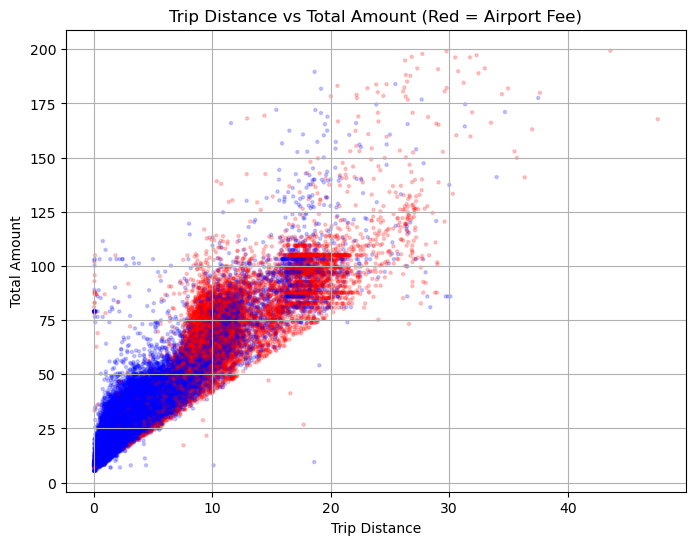

In [98]:
# Select the data including Airport_fee
pandas_df = df.select(["trip_distance", "total_amount", "Airport_fee"]) \
              .limit(100000).toPandas()

# Define colors: red if Airport_fee == 1, else blue
colors = pandas_df['Airport_fee'].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title("Trip Distance vs Total Amount (Red = Airport Fee)")
plt.grid(True)
plt.show()

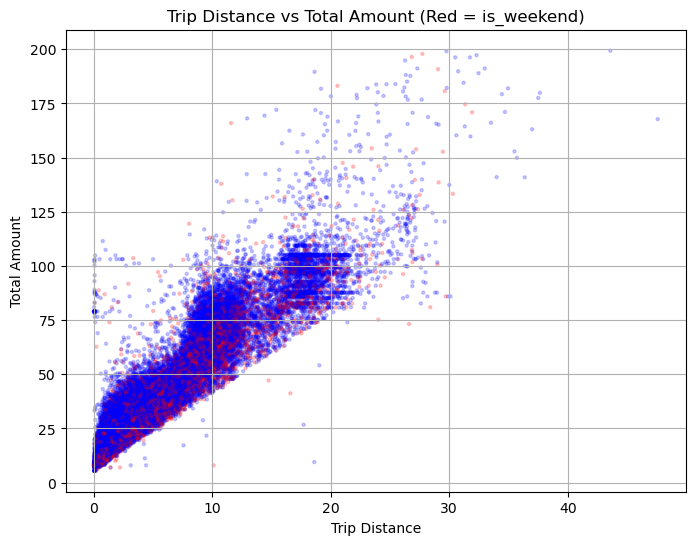

In [99]:
feature = 'is_weekend' #'is_holiday' #'is_shared_ride' 
pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

# Define colors: red if col == 1, else blue
colors = pandas_df[feature].apply(lambda x: 'red' if x == 1 else 'blue')

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], c=colors, alpha=0.2, s=5)
plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount (Red = {feature})")
plt.grid(True)
plt.show()

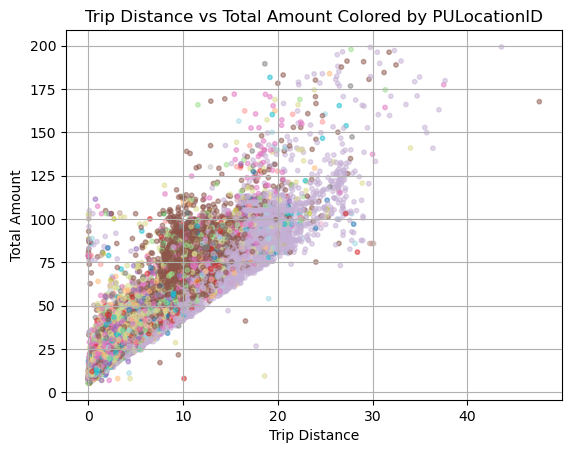

In [100]:
# Scatter plot, color by col
feature ='PULocationID'#'hour'

pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

scatter = plt.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    c=pandas_df[feature],
    cmap='tab20',       # or 'viridis', 'Set1', etc.
    alpha=0.5,
    s=10
)

plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount Colored by {feature}")
plt.grid(True)

plt.show()

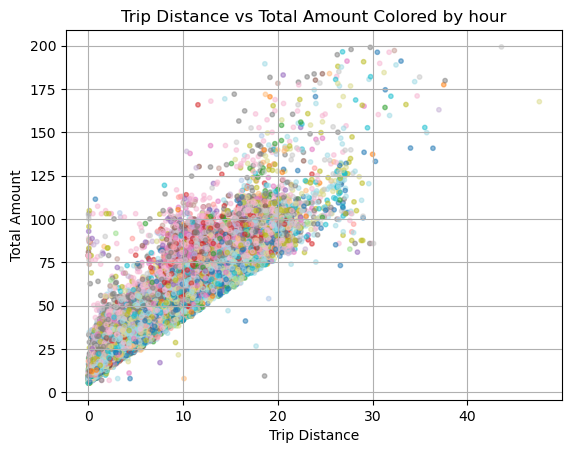

In [101]:
# Scatter plot, color by col
feature = 'hour'

pandas_df = df.select(["trip_distance", "total_amount", feature]) \
              .limit(100000).toPandas()

scatter = plt.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    c=pandas_df[feature],
    cmap='tab20',       # or 'viridis', 'Set1', etc.
    alpha=0.5,
    s=10
)

plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title(f"Trip Distance vs Total Amount Colored by {feature}")
plt.grid(True)

# # Add legend with unique cluster labels
# legend_labels = [f"Cluster {i}" for i in sorted(pandas_df['cluster'].unique())]
# plt.legend(*scatter.legend_elements(), title="Cluster", labels=legend_labels)

plt.show()

In [102]:
# no need for indexer as all values doubles or integers
df.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- is_shared_ride: integer (nullable = true)
 |-- Airport_fee: integer (nullable = true)



In [103]:
df.groupBy(df.columns).count().filter("count > 1").show()

25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:51 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/02 11:49:52 WARN RowBasedKeyValueBatch: Calling spill() on

+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+-----+
|trip_distance|total_amount|PULocationID|DOLocationID|is_holiday|is_weekend|month|day_of_week|hour|is_shared_ride|Airport_fee|count|
+-------------+------------+------------+------------+----------+----------+-----+-----------+----+--------------+-----------+-----+
|         0.01|         5.5|         264|         264|         0|         1|    1|          1|   1|             0|          0|    2|
|         0.01|         7.0|         193|         193|         0|         0|    5|          3|  16|             0|          0|    4|
|         0.01|        7.25|         132|         132|         0|         0|    2|          2|  22|             0|          1|    2|
|         0.01|        7.25|         132|         132|         0|         0|    2|          2|  22|             1|          1|    2|
|         0.01|        7.25|         132|         132|         0|    

In [104]:
assembler = VectorAssembler(inputCols=['trip_distance'],
outputCol='features')
df = assembler.transform(df)

assembler2 = VectorAssembler(inputCols=['trip_distance',
    #'is_holiday',
    #'is_weekend',
    #'month',
    'PULocationID',
    'DOLocationID',
    'day_of_week',
    'hour',
    'is_shared_ride',
    'Airport_fee'], 
outputCol='features2')
df = assembler2.transform(df)

In [108]:
# Split data
train_data, test_data = df.select(['features', 'features2', 'total_amount']).randomSplit([0.8, 0.2], seed=42)
train_data.show(5, truncate=False)

+--------+----------------------------------+------------+
|features|features2                         |total_amount|
+--------+----------------------------------+------------+
|[0.01]  |[0.01,10.0,10.0,4.0,17.0,0.0,0.0] |7.0         |
|[0.01]  |[0.01,10.0,10.0,4.0,18.0,0.0,0.0] |7.0         |
|[0.01]  |[0.01,24.0,24.0,5.0,22.0,0.0,0.0] |30.0        |
|[0.01]  |[0.01,24.0,166.0,7.0,21.0,0.0,0.0]|5.5         |
|[0.01]  |[0.01,26.0,26.0,6.0,3.0,0.0,0.0]  |5.5         |
+--------+----------------------------------+------------+
only showing top 5 rows



In [46]:
# Define Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="total_amount")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Show results
print(f"Root Mean Squared Error (RMSE): {rmse}")
predictions.select("features", "total_amount", "prediction").show(10)

# Model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

25/05/02 10:29:30 WARN Instrumentation: [32ee1a68] regParam is zero, which might cause numerical instability and overfitting.
25/05/02 10:29:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/02 10:29:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE): 6.909733823999099


+--------+------------+------------------+
|features|total_amount|        prediction|
+--------+------------+------------------+
|  [0.01]|        79.0|12.810964246840248|
|  [0.01]|         7.0|12.810964246840248|
|  [0.01]|       93.44|12.810964246840248|
|  [0.01]|        11.4|12.810964246840248|
|  [0.01]|        10.2|12.810964246840248|
|  [0.01]|         9.4|12.810964246840248|
|  [0.01]|        10.2|12.810964246840248|
|  [0.01]|        15.0|12.810964246840248|
|  [0.01]|         9.5|12.810964246840248|
|  [0.01]|         8.0|12.810964246840248|
+--------+------------+------------------+
only showing top 10 rows

Coefficients: [4.903575021188338]
Intercept: 12.761928496628364


In [23]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")

# Train
model = rf.fit(train_data)

25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_0 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_7 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_0 to disk instead.
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_7 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_4 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_4 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_6 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_6 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cache rdd_78_2 in memory! (computed 8.3 MiB so far)
25/04/29 13:05:03 WARN BlockManager: Persisting block rdd_78_2 to disk instead.
25/04/29 13:05:03 WARN MemoryStore: Not enough space to cach

In [24]:
# Predict
predictions = model.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.2f}")

RMSE: 6.76


In [109]:
rf2 = RandomForestRegressor(featuresCol="features2", labelCol="total_amount")

# Train
model2 = rf2.fit(train_data)

25/05/02 11:57:14 WARN MemoryStore: Not enough space to cache rdd_916_1 in memory! (computed 8.3 MiB so far)
25/05/02 11:57:14 WARN BlockManager: Persisting block rdd_916_1 to disk instead.
25/05/02 11:57:14 WARN MemoryStore: Not enough space to cache rdd_916_7 in memory! (computed 12.5 MiB so far)
25/05/02 11:57:14 WARN BlockManager: Persisting block rdd_916_7 to disk instead.
25/05/02 11:57:14 WARN MemoryStore: Not enough space to cache rdd_916_6 in memory! (computed 19.2 MiB so far)
25/05/02 11:57:14 WARN BlockManager: Persisting block rdd_916_6 to disk instead.
25/05/02 11:57:14 WARN MemoryStore: Not enough space to cache rdd_916_4 in memory! (computed 19.2 MiB so far)
25/05/02 11:57:14 WARN BlockManager: Persisting block rdd_916_4 to disk instead.
25/05/02 11:57:14 WARN MemoryStore: Not enough space to cache rdd_916_3 in memory! (computed 3.7 MiB so far)
25/05/02 11:57:14 WARN BlockManager: Persisting block rdd_916_3 to disk instead.
25/05/02 11:57:14 WARN MemoryStore: Not enough 

In [48]:
# Predict with pu, do locations + 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 6.94


In [ ]:
# Extract feature importances
# 'trip_distance', pu, do, 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
importances = model2.featureImportances
importances

SparseVector(7, {0: 0.6591, 1: 0.024, 2: 0.0155, 3: 0.0002, 4: 0.0063, 5: 0.0, 6: 0.295})

In [ ]:
# Predict with 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.69


In [23]:
# Extract feature importances
# 'trip_distance', 'day_of_week', 'hour', 'is_shared_ride', 'Airport_fee'
importances = model2.featureImportances
importances

SparseVector(5, {0: 0.6799, 1: 0.0018, 2: 0.012, 3: 0.0002, 4: 0.3061})

In [ ]:
# Predict with many features
predictions2 = model2.transform(test_data)

# Evaluate
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.85
